In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Исследование сервиса аренды самокатов GoFast.

- Компанией предоставлены данные о некоторых пользователях из нескольких городов, а также об их поездках в трех исходных таблицах:
 * Пользователи — users_go
 
             user_id	уникальный идентификатор пользователя
             name	имя пользователя
             age	возраст
             city	город
             subscription_type	тип подписки (free, ultra) 
 
 * Поездки — rides_go.csv
 
             user_id	уникальный идентификатор пользователя
             distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
             duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
             date	дата совершения поездки
             
 * Подписки — subscriptions_go.csv
 
             subscription_type	тип подписки
             minute_price	стоимость одной минуты поездки по данной подписке
             start_ride_price	стоимость начала поездки
             subscription_fee	стоимость ежемесячного платежа
 
- Необходимо провести исследование данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти
- Общий план работы с предоставленными данными можно представить следующим образом:
 * Загрузка и предварительных анализ данных(на наличие дефектов);
 * Агрегация данных по таблицам в соответствии с задачами исследования(требованиями заказчика);
 * Предварительное исследование данных (влияние частоты встречаемости городов, соотношение пользователей по типу подписки, возрастные категории пользователей, расстояние преодолеваемое пользователями за одну поездку, продолжительность поездок);
 * Оценить выручку получаемую с пользователей с подпиской и без;
 * Проверить гипотезы: 
         - тратят ли пользователи с подпиской больше времени на поездки;
         - можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
         - будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
  * Определить тип теста  для проверки гипотезы о снижении количества обращения в службу поддержки при обновлении мобильного приложения;
  * Определить необходимое число промокодов по привлечению клиентов к подписке "ultra" исходя из требования о 100 новых подписчиках с 95 % вероятностью по итогам акции;
  * Оценить вероятность открытия push-уведомлений клиентами мобильного приложения;
  * Сделать выводы про проведенной работе.

### Шаг 1. Загрузка данных

Чтение исходных данных в таблицы:

In [5]:
sept = ","
try:
    rides = pd.read_csv('rides_go.csv', sep = sept)
    subscriptions = pd.read_csv('subscriptions_go.csv', sep = sept)
    users = pd.read_csv('users_go.csv', sep = sept)
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', sep = sept)
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv', sep = sept)
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', sep = sept)

Для автоматизации предобработки данных создадим функцию prep_data:

In [6]:
def prep_data (set):
    print(f'------------------------------------------------------------------------------------')
    count_nan = set.isna().sum().sum()
    count_dubl = set.duplicated().sum()
    n= set.shape[1]
    l= set.shape[0]
    k=len(set.select_dtypes(['number']).columns)
    print('Количество NaN в таблице:', count_nan)
    print('Количество строк в таблице:', l)
    print('Количество столбцов в таблице:', n )
    print('Количество числовых столбцов в таблице:', k)
    if count_dubl == 0:
        print('Явных дубликатов нет')
    else:
        print('Количество явных дубликатов в таблице:', count_dubl)
        set.drop_duplicates(inplace = True)
        print('Kоличество дубликатов после удаления явных:', set.duplicated().sum())
    print ('Информация о таблице:')
    set.info();
    fig, ax = plt.subplots(1, k, figsize=(10, 3))
    set.hist(bins = 100, ax=ax)
    #set.hist(bins = 50)
    plt.show()
    print(f'------------------------------------------------------------------------------------')

Исследуем исходные данные: на пропуски, наличие дубликатов, формат данных в столбцах, построим для цифровых столбцов гистограммы для предварительной оценки:

------------------------------------------------------------------------------------
Количество NaN в таблице: 0
Количество строк в таблице: 18068
Количество столбцов в таблице: 4
Количество числовых столбцов в таблице: 3
Явных дубликатов нет
Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


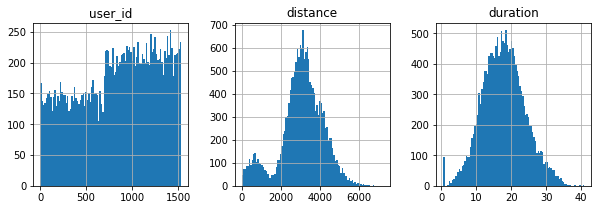

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
Количество NaN в таблице: 0
Количество строк в таблице: 2
Количество столбцов в таблице: 4
Количество числовых столбцов в таблице: 3
Явных дубликатов нет
Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


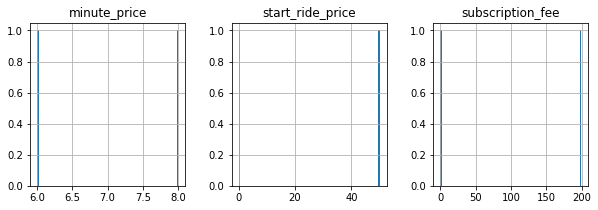

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
Количество NaN в таблице: 0
Количество строк в таблице: 1565
Количество столбцов в таблице: 5
Количество числовых столбцов в таблице: 2
Количество явных дубликатов в таблице: 31
Kоличество дубликатов после удаления явных: 0
Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


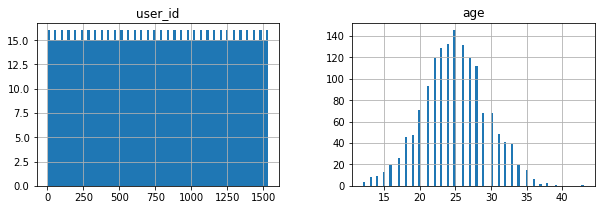

------------------------------------------------------------------------------------


In [7]:
[prep_data(set) for set in [rides, subscriptions, users]];    

 - данные включают три таблицы: rides, subscriptions и users;
 - пропусков значений нет;
 - в таблице users было удален 31 дубликат;
 - таблица rides содержит стоблец с датами, который требует преобразования;
 - данные в столбце duration таблицы rides, похоже содержат аномальные значения в районе 0 и может потребоваться дополнительно исследование;
 - таблица rides и users могут быть объединены по столбцу users_id (не факт, что нужно добавлять данные и из subscriptions, я бы просто сделал столбец типа bool, а данные по подпискам хранил бы отдельно, потому что расскидывать два столбца по всей объединенной тоаблице, может быть не выходно с точки зрения хранения данных - но нас далее просят объединить, значит объединим)

### Шаг 2. Предобработка данных

2.1 Приводим столбец date к типу даты pandas:

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

2.2 Создаем новый столбец с номером месяца на основе столбца

In [9]:
rides['month_of_ride'] = rides['date'].dt.month

### Шаг 3. Исследовательский анализ данных

Описание и визуализация общей информации о пользователях и поездках. Анализ целесообразно выполнять, после систематизации исходных данных, в том числе объединения в единый dataframe

Конструкция итоговой таблицы (столбцы):

user_id (float) - city (object) - date (time) - month_of_ride(int) - duration (float) - distance (float) - name(object) - age (float) - subscription_type (object) - minute_price (int) - start_ride_price(int) - subscription_fee(int)


In [10]:
full_data = ( rides.merge(users, how='outer', left_on='user_id', right_on='user_id')
             .merge(subscriptions, how='outer', left_on='subscription_type', right_on='subscription_type')
            )

In [11]:
full_data = full_data[['user_id', 'city', 'date', 'month_of_ride', 'duration', 'distance', 'name', \
                       'age', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']]

3.1 Частота встречаемости городов:

При анализе встречаемости городов, вероятно интерес могут представлять две характеристики:

- распределение городов по количеству поездок;
- распределение городов по числу уникальных зарегистрированных пользователей.

  В первом случае это показатель, насколько активно используется сервис клиентами, а во втором случае это показатель охвата пользователей.
  Выведем обе метрики

In [12]:
town_analize= pd.pivot_table(full_data, index=['city', 'user_id'], values = 'name', aggfunc = ['count']).reset_index()
town_analize.columns = ['city', 'user_id','frequently']

In [13]:
freq_town_per_smthg = pd.pivot_table(town_analize, index=['city'], values = 'frequently', aggfunc = ['count', 'sum']).reset_index()
freq_town_per_smthg.columns = ['city', 'per_person', 'per_ride']
freq_town_per_smthg['ride_per_person'] =  freq_town_per_smthg['per_ride'] /freq_town_per_smthg['per_person'] 
freq_town_per_smthg

,city,per_person,per_ride,ride_per_person
0,Екатеринбург,204,2461,12.063725
1,Краснодар,193,2301,11.922280
2,Москва,168,1875,11.160714
3,Омск,183,2077,11.349727
4,Пятигорск,219,2524,11.525114
5,Ростов-на-Дону,198,2450,12.373737
6,Сочи,189,2259,11.952381
7,Тюмень,180,2121,11.783333


In [14]:
freq_town_per_smthg['per_ride'] = freq_town_per_smthg['per_ride']/freq_town_per_smthg['per_ride'].sum()
freq_town_per_smthg['per_person'] = freq_town_per_smthg['per_person'] / freq_town_per_smthg['per_person'].sum()
freq_town_per_smthg.sort_values(by ='per_ride', ascending=False, inplace = True)

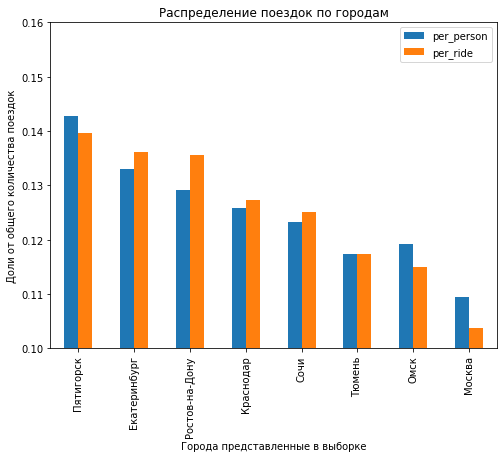

In [52]:
ax= freq_town_per_smthg.plot(x='city', y=['per_person', 'per_ride'], kind='bar',\
                             figsize=(8,6), title="Распределение поездок по городам");
ax.set_xlabel("Города представленные в выборке")
ax.set_ylabel("Доли от общего количества поездок")
plt.ylim(0.10,0.16);

- Интересно, что сервис пользуется наибольшей популярностью в Пятигорске, а наименьшей в Москве;
- В Пятигорске, Омске и Москве пользователи наименее активны, а в Екатеринбурге и Ростове-на-Дону наоборот в среднем каждый совершает больше поездок;
- Доли городов варьируются от 10 до 14%, таким образом аномалий на представленных данных отсутствуют;
- Для более подробного анализа, вероятно требуется знать размер парка самокатов в каждом городе и объем целевой аудитории.

3.2. Соотношение пользователей с подпиской и без подписки

Раз уже разбили по городам, можно сделать здесь оценку так же в зависимости от города.

In [16]:
subscribe_analize= pd.pivot_table(full_data, index=['city', 'subscription_type'], values = 'user_id', aggfunc = lambda x: len(x.unique())).reset_index()
#subscribe_analize.columns = ['city', 'subscription_type','frequently']

In [17]:
subscribe_per_city = (subscribe_analize[(subscribe_analize['subscription_type']=='ultra')][['city', 'user_id']]
             .merge(subscribe_analize[subscribe_analize['subscription_type']=='free'][['city', 'user_id']], how='outer', left_on='city', right_on='city')
            )
subscribe_per_city.columns = ['city', 'subscription == ultra', 'subscription == free']
subscribe_per_city ['subscription == ultra']= subscribe_per_city ['subscription == ultra']/ (subscribe_per_city ['subscription == ultra'] + subscribe_per_city ['subscription == free'])
subscribe_per_city ['subscription == free'] = 1-subscribe_per_city ['subscription == ultra']
subscribe_per_city.sort_values(by ='subscription == ultra', ascending=False, inplace = True)
subscribe_per_city.reset_index(drop=True)

,city,subscription == ultra,subscription == free
0,Москва,0.500000,0.500000
1,Омск,0.497268,0.502732
2,Тюмень,0.455556,0.544444
3,Сочи,0.455026,0.544974
4,Екатеринбург,0.450980,0.549020
5,Ростов-на-Дону,0.449495,0.550505
6,Пятигорск,0.429224,0.570776
7,Краснодар,0.419689,0.580311


In [18]:
print ('Общая доля пользователей с подпиской  ultra:', subscribe_per_city ['subscription == ultra'].sum()/8)
print ('Общая доля пользователей с подпиской  free:', subscribe_per_city ['subscription == free'].sum()/8)

Общая доля пользователей с подпиской  ultra: 0.4571547469074858
Общая доля пользователей с подпиской  free: 0.5428452530925143


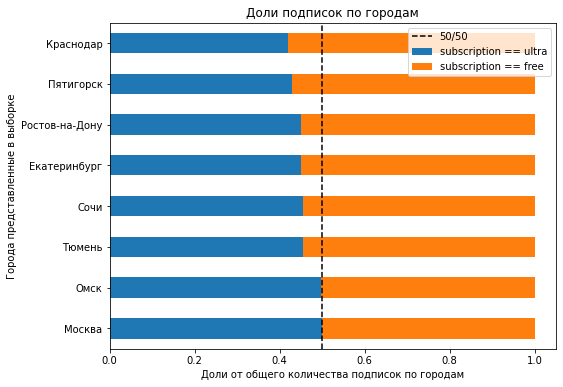

In [53]:
ax =subscribe_per_city.plot(x='city', kind = 'barh',  stacked = True,  title = 'Доли подписок по городам',\
                            mark_right = True, figsize=(8,6));
plt.axvline(x=0.5, color = 'k', linestyle='dashed', label = '50/50');
ax.set_xlabel("Доли от общего количества подписок по городам")
ax.set_ylabel("Города представленные в выборке")
plt.legend();

 - Во всех города количество пользователей с подпиской free, больше чем в ultra (только в Москве и Омске, их практически одинаковое количество);
 - Аномальных значений в распределении по городам нет - значения соответствуют общим средним; 
 - Самое большое значение подписки ultra в Москве и Омске, самое низкое в Краснодаре и Пятигорске.

3.3 Возраст пользователей

Скорее всего по городам различий нет, интересно посмотреть наличие подписки по возрасту......  вполне возможно, что более молодые активнее подписываются на платные опции.

In [20]:
age_analize= pd.pivot_table(full_data, index=['city', 'user_id', 'subscription_type'], values = ['age']).reset_index()

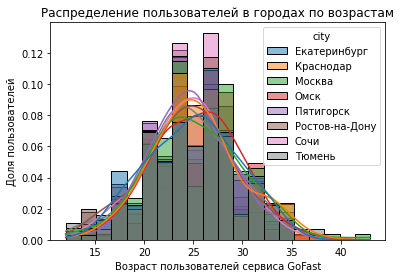

In [21]:
ax= sns.histplot(data = age_analize, x = 'age', bins=20, hue="city", kde=True, stat="density", common_norm=False); 
ax.set_title("Распределение пользователей в городах по возрастам");
ax.set_xlabel("Возраст пользователей сервиса GoFast");
ax.set_ylabel("Доля пользователей");

Оно конечно наслаивается, но похоже, что максимум примерно в одном и том же месте - около 25 лет, дисперсия похожа. В Москве есть немного пользователей старшего возраста, около 40 лет (прогрессивные люди). На данном этапе нет смысла продолжать исследование в этом направлении.

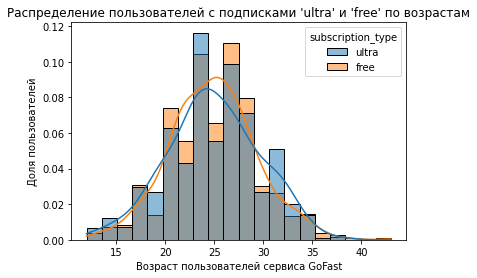

In [22]:
ax = sns.histplot(data = age_analize, x = 'age', bins=20, hue="subscription_type", kde=True, stat="density", common_norm=False); 
ax.set_title("Распределение пользователей с подписками 'ultra' и 'free' по возрастам")
ax.set_xlabel("Возраст пользователей сервиса GoFast");
ax.set_ylabel("Доля пользователей");

In [23]:
print('Медианное значение возраста людей с подпиской', age_analize[age_analize["subscription_type"]=='free']['age'].quantile(0.5))
print('Медианное значение возраста людей без подписки', age_analize[age_analize["subscription_type"]=='ultra']['age'].quantile(0.5))

Медианное значение возраста людей с подпиской 25.0
Медианное значение возраста людей без подписки 25.0


Интересно отметить, что эти значения "очень" равны

3.4 Расстояние, которое пользователь преодолел за одну поездку

In [24]:
dist_analize= pd.pivot_table(full_data, index=['city', 'user_id', 'subscription_type'], values = ['distance'], aggfunc = 'mean').reset_index()

In [25]:
dist_analize

,city,user_id,subscription_type,distance
0,Екатеринбург,10,ultra,2952.822611
1,Екатеринбург,41,ultra,3566.522091
2,Екатеринбург,42,ultra,2847.760236
3,Екатеринбург,59,ultra,2865.230001
4,Екатеринбург,63,ultra,3589.391414
...,...,...,...,...
1529,Тюмень,1513,free,3140.981561
1530,Тюмень,1514,free,2729.940458
1531,Тюмень,1517,free,3099.206698
1532,Тюмень,1519,free,3240.691224


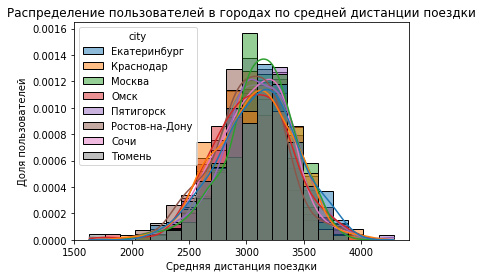

In [26]:
ax = sns.histplot(data = dist_analize, x = 'distance', bins=20, hue="city", kde=True, stat="density", common_norm=False); 
ax.set_title("Распределение пользователей в городах по средней дистанции поездки")
ax.set_xlabel("Средняя дистанция поездки");
ax.set_ylabel("Доля пользователей");

Интересно, что средняя дистанция поездки практически не зависит от города, хотя Москва больше Пятигорска

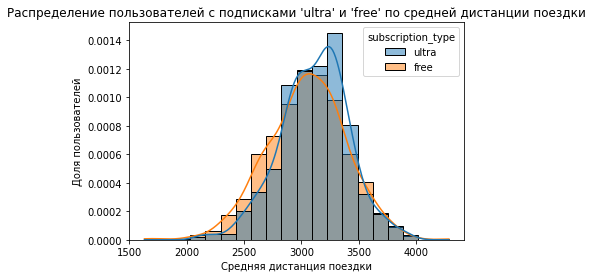

In [27]:
ax =sns.histplot(data = dist_analize, x = 'distance', bins=20, hue="subscription_type", kde=True, stat="density", common_norm=False);
ax.set_title("Распределение пользователей с подписками 'ultra' и 'free' по средней дистанции поездки")
ax.set_xlabel("Средняя дистанция поездки");
ax.set_ylabel("Доля пользователей");

In [28]:
print('Медианное значение расстояния без подписки ',dist_analize[dist_analize["subscription_type"]=='free']['distance'].quantile(0.5))
print('Медианное значение расстояния с подпиской',dist_analize[dist_analize["subscription_type"]=='ultra']['distance'].quantile(0.5))

Медианное значение расстояния без подписки  3057.9409092252563
Медианное значение расстояния с подпиской 3134.34918640824


А вот у людей с подпиской средняя продолжительность поездки несколько выше, на 100 метров. Если отнести эту разницу к любому из средних значений это совсем немного, но заметно по диаграммам.

3.5 Продолжительность поездок

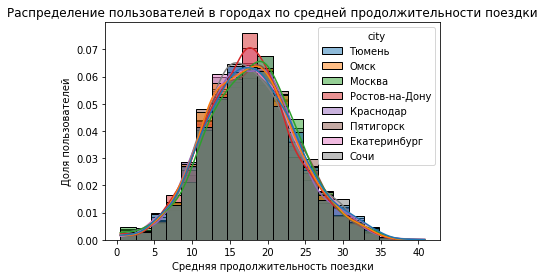

In [29]:
ax =sns.histplot(data = full_data, x = 'duration', bins=20, hue="city", kde=True, stat="density", common_norm=False); 
ax.set_title("Распределение пользователей в городах по средней продолжительности поездки")
ax.set_xlabel("Средняя продолжительность поездки");
ax.set_ylabel("Доля пользователей");

Продолжительность поездки не сильно зависит от города.

In [30]:
print('Медианное значение продолжительности поездки, мин:',full_data['duration'].quantile(0.5))

Медианное значение продолжительности поездки, мин: 17.678394530393803


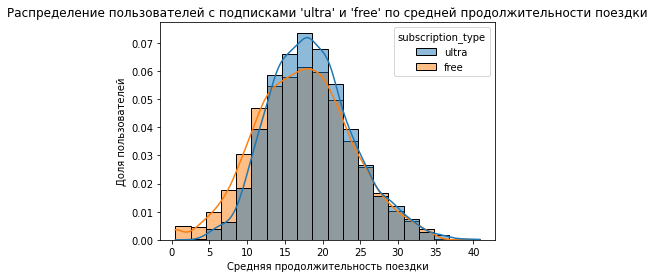

In [31]:
ax =sns.histplot(data = full_data, x = 'duration', bins=20, hue="subscription_type", kde=True, stat="density", common_norm=False); 
ax.set_title("Распределение пользователей с подписками 'ultra' и 'free' по средней продолжительности поездки")
ax.set_xlabel("Средняя продолжительность поездки");
ax.set_ylabel("Доля пользователей");

In [32]:
print('Медианное значение продолжительности поездки без подписки ',full_data[full_data["subscription_type"]=='free']['duration'].quantile(0.5))
print('Медианное значение продолжительности поездки с подпиской',full_data[full_data["subscription_type"]=='ultra']['duration'].quantile(0.5))

Медианное значение продолжительности поездки без подписки  17.326890226082043
Медианное значение продолжительности поездки с подпиской 18.17815320055055


Похоже, что длительность поездок не сильно зависит от типа подписки(+1 минута), но мы еще проверим более подробно в пункте 6.1

### Шаг 4. Объединение данных

4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм выполнее ранее, здесь разобьем по типу подписки free и ultra (пункт 4.2)

In [33]:
full_data_subsc_free  = full_data[(full_data['subscription_type']=='free')].reset_index(drop = True)
full_data_subsc_ultra = full_data[(full_data['subscription_type']=='ultra')].reset_index(drop = True)

4.3 Информация о расстоянии и времени поездок для пользователей обеих категорий. Так как речь идет о всех поездках, то нет смысла группировать по пользователям. При этом визуализация для длительности поездок по категории подписки была выполнена в пунтке 3.5, а вот по расстоянию для всех поездок выполним тут. И при использовании sns.histplot подойдет и исходная таблица full_data.

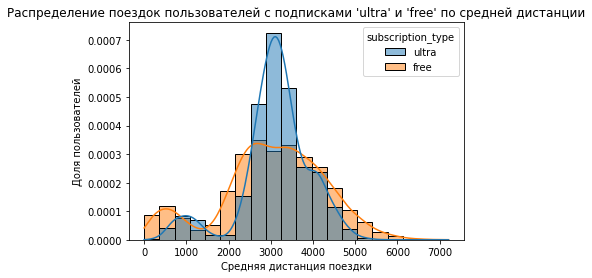

In [34]:
ax = sns.histplot(data = full_data, x = 'distance', bins=20, hue="subscription_type", kde=True, stat="density", common_norm=False);
ax.set_title("Распределение поездок пользователей с подписками 'ultra' и 'free' по средней дистанции")
ax.set_xlabel("Средняя дистанция поездки");
ax.set_ylabel("Доля пользователей");

Если не осреднять дистанцию поезкди по отдельному пользователю, а рассматривать всю их совокупность, можно отметить следующее: 

- люди с подпиской более системно относятся к перемещению на самокатах, решая прикладные задачи перемещения по городу - здесь наблюдается меньшая дисперсия вокруг медианного расстояния около 3148 м;
- дистация поездки для людей без подписки более равномерно распределена, по сравнению с подпиской ultra, что может характеризовать "развлекательную" цель поездок, при этом средняя дистанция составляет порядка 3114 м;
- разница медианных значений расстояния по подписки и без - незначительна;
- в районе 1 км наблюдается локальный максимум "коротких" поездок, который отсутствует при рассмотрении данных "по пользователям".

In [35]:
print('Медианное значение расстояния без подписки',full_data[full_data["subscription_type"]=='free']['distance'].quantile(0.5))
print('Медианное значение расстояния с подписки',full_data[full_data["subscription_type"]=='ultra']['distance'].quantile(0.5))

Медианное значение расстояния без подписки 3114.648464847295
Медианное значение расстояния с подписки 3148.6372291760854


### Шаг 5. Подсчёт выручки

5.1.Суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [36]:
months_data= pd.pivot_table(full_data, index=[ 'month_of_ride', 'user_id'], values = ['distance', 'name', 'duration', 'subscription_type'], \
                            aggfunc ={"distance":"sum", "name":"count", "duration":lambda x: np.ceil(x).sum(), 'subscription_type': 'first'}).reset_index()
months_data.columns = ['month_of_ride' ,'user_id' ,'sum_distance', 'sum_duration', 'count_ride' , 'subscription_type']
months_data.head(15)

,month_of_ride,user_id,sum_distance,sum_duration,count_ride,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,3,3061.777147,13.0,1,ultra
2,1,5,3914.646990,13.0,1,ultra
3,1,7,6478.080979,28.0,2,ultra
4,1,12,3577.151148,33.0,1,ultra
5,1,13,6687.987446,42.0,2,ultra
6,1,14,7699.643820,35.0,2,ultra
7,1,15,4187.621459,39.0,1,ultra
8,1,20,3516.719208,29.0,1,ultra
9,1,22,3058.692225,13.0,1,ultra


5.2. Добавить столбец с помесячной выручкой, которую принёс каждый пользователь

In [37]:
def money_spent (row):
    x = row['subscription_type'] == 'ultra'
    return  x*(row['sum_duration']*6 + 199) + (1-x)*(row['sum_duration']*8 + 50*row['count_ride'])    

In [38]:
def money_spent_dyn (row):
    x = int(row['subscription_type'] == 'ultra')                         # просто очень хотелось без явных if/else
    return subscriptions.loc[x]['minute_price']*row['sum_duration'] \
    + subscriptions.loc[x]['start_ride_price']*row['count_ride'] +subscriptions.loc[x]['subscription_fee']

In [39]:
months_data['profit'] = months_data.apply(money_spent_dyn, axis=1)
months_data.head(5)

,month_of_ride,user_id,sum_distance,sum_duration,count_ride,subscription_type,profit
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,3,3061.777147,13.0,1,ultra,277.0
2,1,5,3914.646990,13.0,1,ultra,277.0
3,1,7,6478.080979,28.0,2,ultra,367.0
4,1,12,3577.151148,33.0,1,ultra,397.0


### Шаг 6. Проверка гипотез

6.1. Тратят ли пользователи с подпиской больше времени на поездки

Проверим гипотезу о том, что пользователи с подпиской "ultra" катаются на самокатах дольше:

- Нулевая гипотеза: средние значения времени для двух групп равны.
- Альтернативная гипотеза: среднее значение времени использования самоката пользователями с подпиской "ultra" больше, чем среднее значение пользователей с подпиской "free"

In [40]:
alpha = 0.05
ultra_group = full_data_subsc_ultra['duration']
free_group  = full_data_subsc_free['duration']

results = st.ttest_ind(ultra_group, free_group, alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем H0 гипотезу')
else:
    print('Нет оснований отвергнуть H0 гипотезу')
print('Среднее значение продолжительности поездки без подписки, мин', full_data_subsc_free['duration'].mean())
print('Среднее значение продолжительности поездки с подпиской, мин',  full_data_subsc_ultra['duration'].mean())

p-value: 1.2804098316645618e-34
Отвергаем H0 гипотезу
Среднее значение продолжительности поездки без подписки, мин 17.39090929866399
Среднее значение продолжительности поездки с подпиской, мин 18.54198516280583


Есть основания говорить, что пользователи с подпиской "ultra" катаются дольше.

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Проверим гипотезу о том, что пользователи с подпиской "ultra" катаясь на самокатах не превышают оптимальное расстояние для износа самоката:

- Нулевая гипотеза: средние значения расстояния поездки равно 3130 метров для пользователей с подпиской.
- Альтернативная гипотеза: средние значения расстояния поездки пользователями с подпиской "ultra" больше, чем 3130 метров.

In [41]:
alpha = 0.1
ultra_distance = full_data_subsc_ultra['distance']
wearing_limit = 3130 

results = st.ttest_1samp(ultra_distance, wearing_limit, alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем H0 гипотезу')
else:
    print('Нет оснований отвергнуть H0 гипотезу')
print('Оптимальное расстояние поездки с точки зрения износа самоката, м', wearing_limit)
print('Среднее значение продолжительности поездки с подпиской, м',  full_data_subsc_ultra['distance'].mean())

p-value: 0.9195368847849785
Нет оснований отвергнуть H0 гипотезу
Оптимальное расстояние поездки с точки зрения износа самоката, м 3130
Среднее значение продолжительности поездки с подпиской, м 3115.4453880370247


По имеющимся данным мы не можем утверждать, что пользователи с подпиской совершают поездки в среднем длинее чем 3130 м

6.3 Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [42]:
profit_by_month =pd.pivot_table(months_data, index=['month_of_ride', 'subscription_type'], values = ['profit'], 
                            aggfunc ='sum').reset_index()
profit_by_month = (profit_by_month[(profit_by_month['subscription_type']=='ultra')][['month_of_ride', 'profit']]
             .merge(profit_by_month[profit_by_month['subscription_type']=='free'][['month_of_ride', 'profit']], how='outer', left_on='month_of_ride', right_on='month_of_ride')
            )
profit_by_month.columns = ['month_of_ride', 'profit == ultra', 'profit == free']
profit_by_month ['profit == ultra(%)']= profit_by_month ['profit == ultra']/ (profit_by_month ['profit == ultra'] + profit_by_month ['profit == free'])
profit_by_month ['profit == free(%)'] = 1-profit_by_month ['profit == ultra(%)']
profit_by_month

,month_of_ride,profit == ultra,profit == free,profit == ultra(%),profit == free(%)
0,1,144108.0,193850.0,0.426408,0.573592
1,2,124572.0,165856.0,0.428926,0.571074
2,3,142608.0,187214.0,0.432379,0.567621
3,4,137318.0,185598.0,0.425244,0.574756
4,5,149235.0,188030.0,0.442486,0.557514
5,6,143834.0,192144.0,0.428105,0.571895
6,7,143466.0,185038.0,0.436725,0.563275
7,8,138534.0,187116.0,0.425408,0.574592
8,9,129337.0,193700.0,0.400378,0.599622
9,10,133932.0,181428.0,0.424696,0.575304


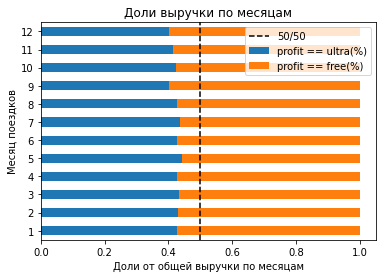

In [43]:
ax =profit_by_month[['month_of_ride', 'profit == ultra(%)', 'profit == free(%)']].plot(x='month_of_ride', kind = 'barh',  stacked = True,  title = 'Доли выручки по месяцам',  mark_right = True);
plt.axvline(x=0.5, color = 'k', linestyle='dashed', label = '50/50');
ax.set_xlabel("Доли от общей выручки по месяцам");
ax.set_ylabel("Месяц поездков");
plt.legend();

Проверим данную гипотезу классическим образом:

- Нулевая гипотеза: средние значения выручки по месяцам поездок равно для пользователей с подпиской и без.
- Альтернативная гипотеза: средние значения  выручки по месяцам поездок пользователей с подпиской "ultra" больше, чем для пользователей без подписки.

Так как это t-test и 12 месяцев сойдет за выборку

In [44]:
alpha = 0.05
ultra_group = profit_by_month['profit == ultra']
free_group  = profit_by_month['profit == free']

results = st.ttest_ind(ultra_group, free_group, alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем H0 гипотезу')
else:
    print('Нет оснований отвергнуть H0 гипотезу')
print('Среднее значение трат за месяц пользователей без подписки, руб', profit_by_month['profit == free'].mean())
print('Среднее значение трат за месяц пользователей с подпиской, руб',  profit_by_month['profit == ultra'].mean())

p-value: 0.9999999999997602
Нет оснований отвергнуть H0 гипотезу
Среднее значение трат за месяц пользователей без подписки, руб 186175.33333333334
Среднее значение трат за месяц пользователей с подпиской, руб 137044.75


Гипотеза о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки не подтверждается.

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Односторонная(правая) гипотеза о равенстве среднего генеральной совокупности для зависимых (парных) выборок.

- Нулевая гипотеза: средние значения обращений пользователей из двух групп равны.
- Альтернативная гипотеза: среднее значение обращений пользователей до обновления больше, чем среднее значение обращений пользователей после обновления.

Метод: scipy.stats.ttest_rel(before_group, after_group, alternative='greater')

### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 
5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодо.в

In [45]:
p=0.1                              # вероятность успеха из предыдущего опыта
q=0.05                             # вероятность не выполнить план сейчас
target = 100                       # целевое значение подписок
N=int(target*p)                    # стартовое значение розданных промокодов
value = 0                          # инициализация значения подписок
while value<target:
    value = st.binom.ppf(1-q, N, p)
    N +=1
print('Hеобходимое число розданных промокодов',N)

Hеобходимое число розданных промокодов 851


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


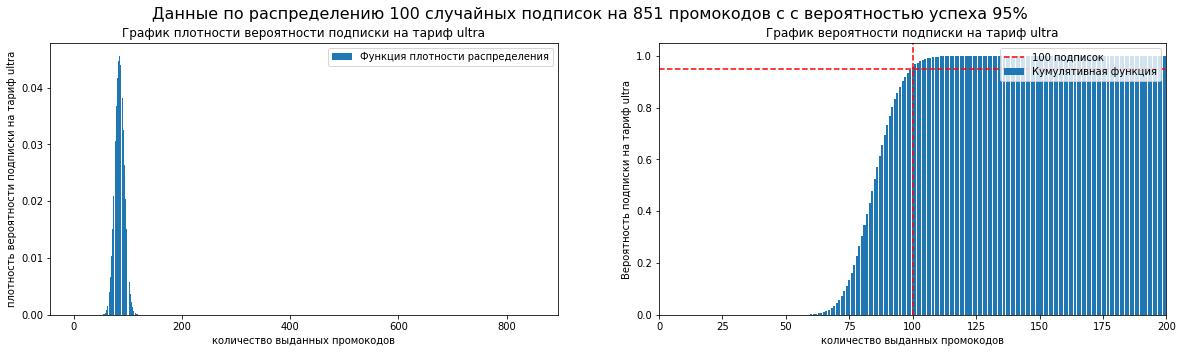

In [46]:
distr_bi_pmf = []
distr_bi_cdf = []
for k in range(0, N + 1):
    current_value = st.binom.pmf(k, N, p)
    distr_bi_pmf.append(current_value)
    current_value = st.binom.cdf(k, N, p)
    distr_bi_cdf.append(current_value)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))   
fig.suptitle('Данные по распределению 100 случайных подписок на 851 промокодов c c вероятностью успеха 95%', fontsize=16)
ax[0].bar(range(0, N + 1), distr_bi_pmf, label = 'Функция плотности распределения');
ax[0].set_xlabel("количество выданных промокодов");
ax[0].set_ylabel("плотность вероятности подписки на тариф ultra");
ax[0].set_title("График плотности вероятности подписки на тариф ultra")
ax[0].legend(loc='upper right');
ax[1].bar(range(0, N + 1), distr_bi_cdf, label = 'Кумулятивная функция');
ax[1].axvline(x=100, color = 'r', linestyle='dashed', label = '100 подписок');
ax[1].axhline(y=0.95, color = 'r', linestyle='dashed');
ax[1].set_title("График вероятности подписки на тариф ultra")
ax[1].set_xlabel("количество выданных промокодов");
ax[1].set_ylabel("Вероятность подписки на тариф ultra");
ax[1].legend(loc='upper right');
ax[1].set_xlim([0, 200]);


7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей

In [47]:
p=0.4
N = 1e6
k = 399.5e3
left  = p*N-3*np.sqrt(N * p * (1 - p))
right = p*N+3*np.sqrt(N * p * (1 - p))
if (right<= N) and (left>=0):
    print ('Можно использовать эквивалентное нормальное распределение')
else:
    print ('Нельзя использовать эквивалентное нормальное распределение')

Можно использовать эквивалентное нормальное распределение


Эквивалетное нормальное распределение

In [48]:
mu = N * p
sigma = np.sqrt(N * p * (1 - p))
distr = st.norm(mu, sigma) 
print('Вероятность что уведомления откроют не более 399,5 тыс. пользователей:',distr.cdf(k))

Вероятность что уведомления откроют не более 399,5 тыс. пользователей: 0.15371708296369768


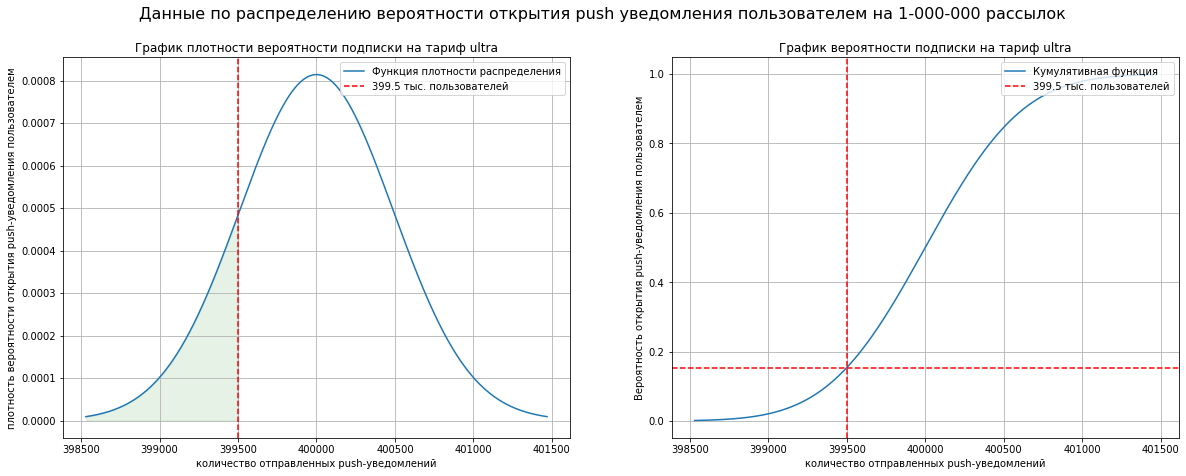

In [49]:
x = np.linspace(left, right, 1000)
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Данные по распределению вероятности открытия push уведомления пользователем на 1-000-000 рассылок', fontsize=16)
ax[0].plot(x, distr.pdf(x), label = 'Функция плотности распределения')
ax[0].axvline(x=k, color = 'r', linestyle='dashed', label = '399.5 тыс. пользователей');
ax[0].fill_between(x,distr.pdf(x),0,where=(x>left) & (x<=k),color='g', alpha=0.1)
ax[0].grid()
ax[0].set_xlabel("количество отправленных push-уведомлений");
ax[0].set_ylabel("плотность вероятности открытия push-уведомления пользователем");
ax[0].set_title("График плотности вероятности подписки на тариф ultra")
ax[0].legend(loc='upper right');
ax[1].plot(x, distr.cdf(x), label = 'Кумулятивная функция')
ax[1].axvline(x=k, color = 'r', linestyle='dashed', label = '399.5 тыс. пользователей');
ax[1].axhline(y=distr.cdf(k), color = 'r', linestyle='dashed');
ax[1].grid()
ax[1].set_title("График вероятности подписки на тариф ultra")
ax[1].set_xlabel("количество отправленных push-уведомлений");
ax[1].set_ylabel("Вероятность открытия push-уведомления пользователем");
ax[1].legend(loc='upper right');
plt.show()

### Шаг 8. Общие выводы

* Загрузка данных
    * Загружено три таблицы с системным разделителем - запятой;
    * Пропусков данных нет ни в одном из файлов;
    * Файл user содержал 31 явных дубликат;
    * Определены числовые и строчные столбцы, один столбец необходимо переформатировать в тип данных time;
    * Выявлена необходимость в объединении данных в один dataframe.
* Предобработка данных
    * Cтолбец date приведен к типу даты pandas;
    * Создан новый столбец с номером месяца на основе столбца date.
* Исследовательский анализ данных
    * Выполнено объединение в единый dataframe;
    * Cервис пользуется наибольшей популярностью в Пятигорске, а наименьшей в Москве;
    * В Пятигорске, Омске и Москве пользователи наименее активны, а в Екатеринбурге и Ростове-на-Дону наоборот в среднем каждый совершает больше поездок;
    * Доли городов варьируются от 10 до 14%, таким образом аномалий на представленных данных отсутствуют;
    * Для более подробного анализа, вероятно требуется знать размер парка самокатов в каждом городе и объем целевой аудитории;
    * Во всех города количество пользователей с подпиской free, больше чем в ultra (только в Москве и Омске, их практически одинаковое количество);
    * номальных значений в распределении по городам нет - значения соответствуют общим средним;
    * Самое большое значение подписки ultra в Москве и Омске, самое низкое в Краснодаре и Пятигорске
    * Среднее значение возраста составляет 25 лет;
    * В Москве есть немного пользователей старшего возраста, около 40 лет (прогрессивные люди);
    * Средняя дистанция поездки практически не зависит от города;
    * Продолжительность поездки не сильно зависит от города;
    * Медианное значение продолжительности поездки, мин: 18.
* Объединение данных
    * Составлены таблицы с агрегированными данными по типу подписки;
    * Люди с подпиской более системно относятся к перемещению на самокатах, решая прикладные задачи перемещения по городу - здесь наблюдается меньшая дисперсия вокруг медианного расстояния около 3148 м;
    * Дистация поездки для людей без подписки более равномерно распределена, по сравнению с подпиской ultra, что может характеризовать "развлекательную" цель поездок, при этом средняя дистанция составляет порядка 3114 м;
    * Разница медианных значений расстояния по подписки и без - незначительна;
    * В районе 1 км наблюдается локальный максимум "коротких" поездок, который отсутствует при рассмотрении данных "по пользователям".
* Подсчёт выручки
    * Добавлены столбцы с выручкой по месяцам и типу подписки.
* Проверка гипотез
    * Гипотеза 1: есть основания говорить, что пользователи с подпиской "ultra" катаются дольше;
    * Гипотеза 2: по имеющимся данным мы не можем утверждать, что пользователи с подпиской совершают поездки в среднем длинее чем 3130 м. Таким образом, уровень износа находится в допустимых пределах;
    * Гипотеза 3: не подтверждается, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Для компании пользователи с подпиской ultra являются постоянными клиентами и даже, то что они приносят меньше дохода не является большой проблемой на стадии развития бизнеса. Необходимо провести дополнительное исследование, что влияет на привлечение новых клиентов и ориентироваться на целевые значения удельной доли постоянных клиентов и прибыли от них для рынка самокатов;
    * Сформулирована односторонная(правая) гипотеза для средних двух генеральных совокупностей для оценки обновления ПО на сервере. 
Нулевая гипотеза: средние значения обращений пользователей из двух групп равн .
Альтернативная гипотеза: среднее значение обращений пользователей до обновления больше, чем среднее значение обращений пользователей после обновлен
* Распределения
    * Hеобходимое раздать 851 промокод, для 95 % уверенности в подписки 100 человек;
    * Вероятность что уведомления откроют не более 399,5 тыс. пользователей составляет порядка 15.4%.
ия.